In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

from pandas_datareader import data as web

import datetime as dt
from IPython.display import display, HTML

Using TensorFlow backend.


In [2]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping
(Yahoo Finance url is unstable, and the weblink may fail to process occasionally, if it happens, just rerun the cell until no error occurs)

In [4]:
# web scrap closing price from 1/1/2016 to the most recent day for every stock
stockNames = ['NVDA', 'MSFT', 'IBM', 'HPE', 'FLEX', 'TSLA', 'ORCL']

def get_stock(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Close']

stocks = []
#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2017, 11, 6))))

## Data Pre-Processing

In [5]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,NVDA_0,NVDA_1,MSFT_1,IBM_1,HPE_1,FLEX_1,TSLA_1,ORCL_1
Date,,,,,,,,
2017-10-31,-0.128356,-0.193190,-0.098342,-0.131953,-0.322986,-0.195530,0.058849,-0.039900
2017-11-01,-0.297315,-0.128356,-0.272928,-0.222069,-0.091124,-0.139667,0.582710,0.064839
2017-11-02,-0.405370,-0.297315,-0.116022,-0.197241,-0.342307,0.195533,-0.354590,-0.054863
2017-11-03,-0.142764,-0.405370,0.076244,-0.257010,-0.004175,-0.094973,-0.841214,-0.079800
2017-11-06,-0.261297,-0.142764,-0.096133,-0.357241,-0.158750,0.240223,0.384977,-0.014962


In [6]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 21
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training

In [13]:
#define model
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, return_sequences=True))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(LSTM(4, stateful=True))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.02)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=500, batch_size=batch_size, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (21, 1, 10)               720       
_________________________________________________________________
activation_7 (Activation)    (21, 1, 10)               0         
_________________________________________________________________
dropout_7 (Dropout)          (21, 1, 10)               0         
_________________________________________________________________
lstm_8 (LSTM)                (21, 4)                   240       
_________________________________________________________________
activation_8 (Activation)    (21, 4)                   0         
_________________________________________________________________
dropout_8 (Dropout)          (21, 4)                   0         
_________________________________________________________________
dense_4 (Dense)              (21, 1)                   5         
Total para

315/315 [==============================] - 0s - loss: 0.0182     
Epoch 191/500
315/315 [==============================] - 0s - loss: 0.0181     
Epoch 192/500
315/315 [==============================] - 0s - loss: 0.0180     
Epoch 193/500
315/315 [==============================] - 0s - loss: 0.0178     
Epoch 194/500
315/315 [==============================] - 0s - loss: 0.0184     
Epoch 195/500
315/315 [==============================] - 0s - loss: 0.0184     
Epoch 196/500
315/315 [==============================] - 0s - loss: 0.0185     
Epoch 197/500
315/315 [==============================] - 0s - loss: 0.0180     
Epoch 198/500
315/315 [==============================] - 0s - loss: 0.0183     
Epoch 199/500
315/315 [==============================] - 0s - loss: 0.0182     
Epoch 200/500
315/315 [==============================] - 0s - loss: 0.0183     
Epoch 201/500
315/315 [==============================] - 0s - loss: 0.0184     
Epoch 202/500
315/315 [==============================]

315/315 [==============================] - 0s - loss: 0.0178     
Epoch 395/500
315/315 [==============================] - 0s - loss: 0.0180     
Epoch 396/500
315/315 [==============================] - 0s - loss: 0.0178     
Epoch 397/500
315/315 [==============================] - 0s - loss: 0.0181     
Epoch 398/500
315/315 [==============================] - 0s - loss: 0.0184     
Epoch 399/500
315/315 [==============================] - 0s - loss: 0.0178     
Epoch 400/500
315/315 [==============================] - 0s - loss: 0.0182     
Epoch 401/500
315/315 [==============================] - 0s - loss: 0.0185     
Epoch 402/500
315/315 [==============================] - 0s - loss: 0.0182     
Epoch 403/500
315/315 [==============================] - 0s - loss: 0.0182     
Epoch 404/500
315/315 [==============================] - 0s - loss: 0.0183     
Epoch 405/500
315/315 [==============================] - 0s - loss: 0.0184     
Epoch 406/500
315/315 [==============================]

## Training Outcome

In [14]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(10, batch_input_shape=(new_batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, return_sequences=True))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.1))
new_model.add(LSTM(4, stateful=True))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.02)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

Training RMSE: 0.6125


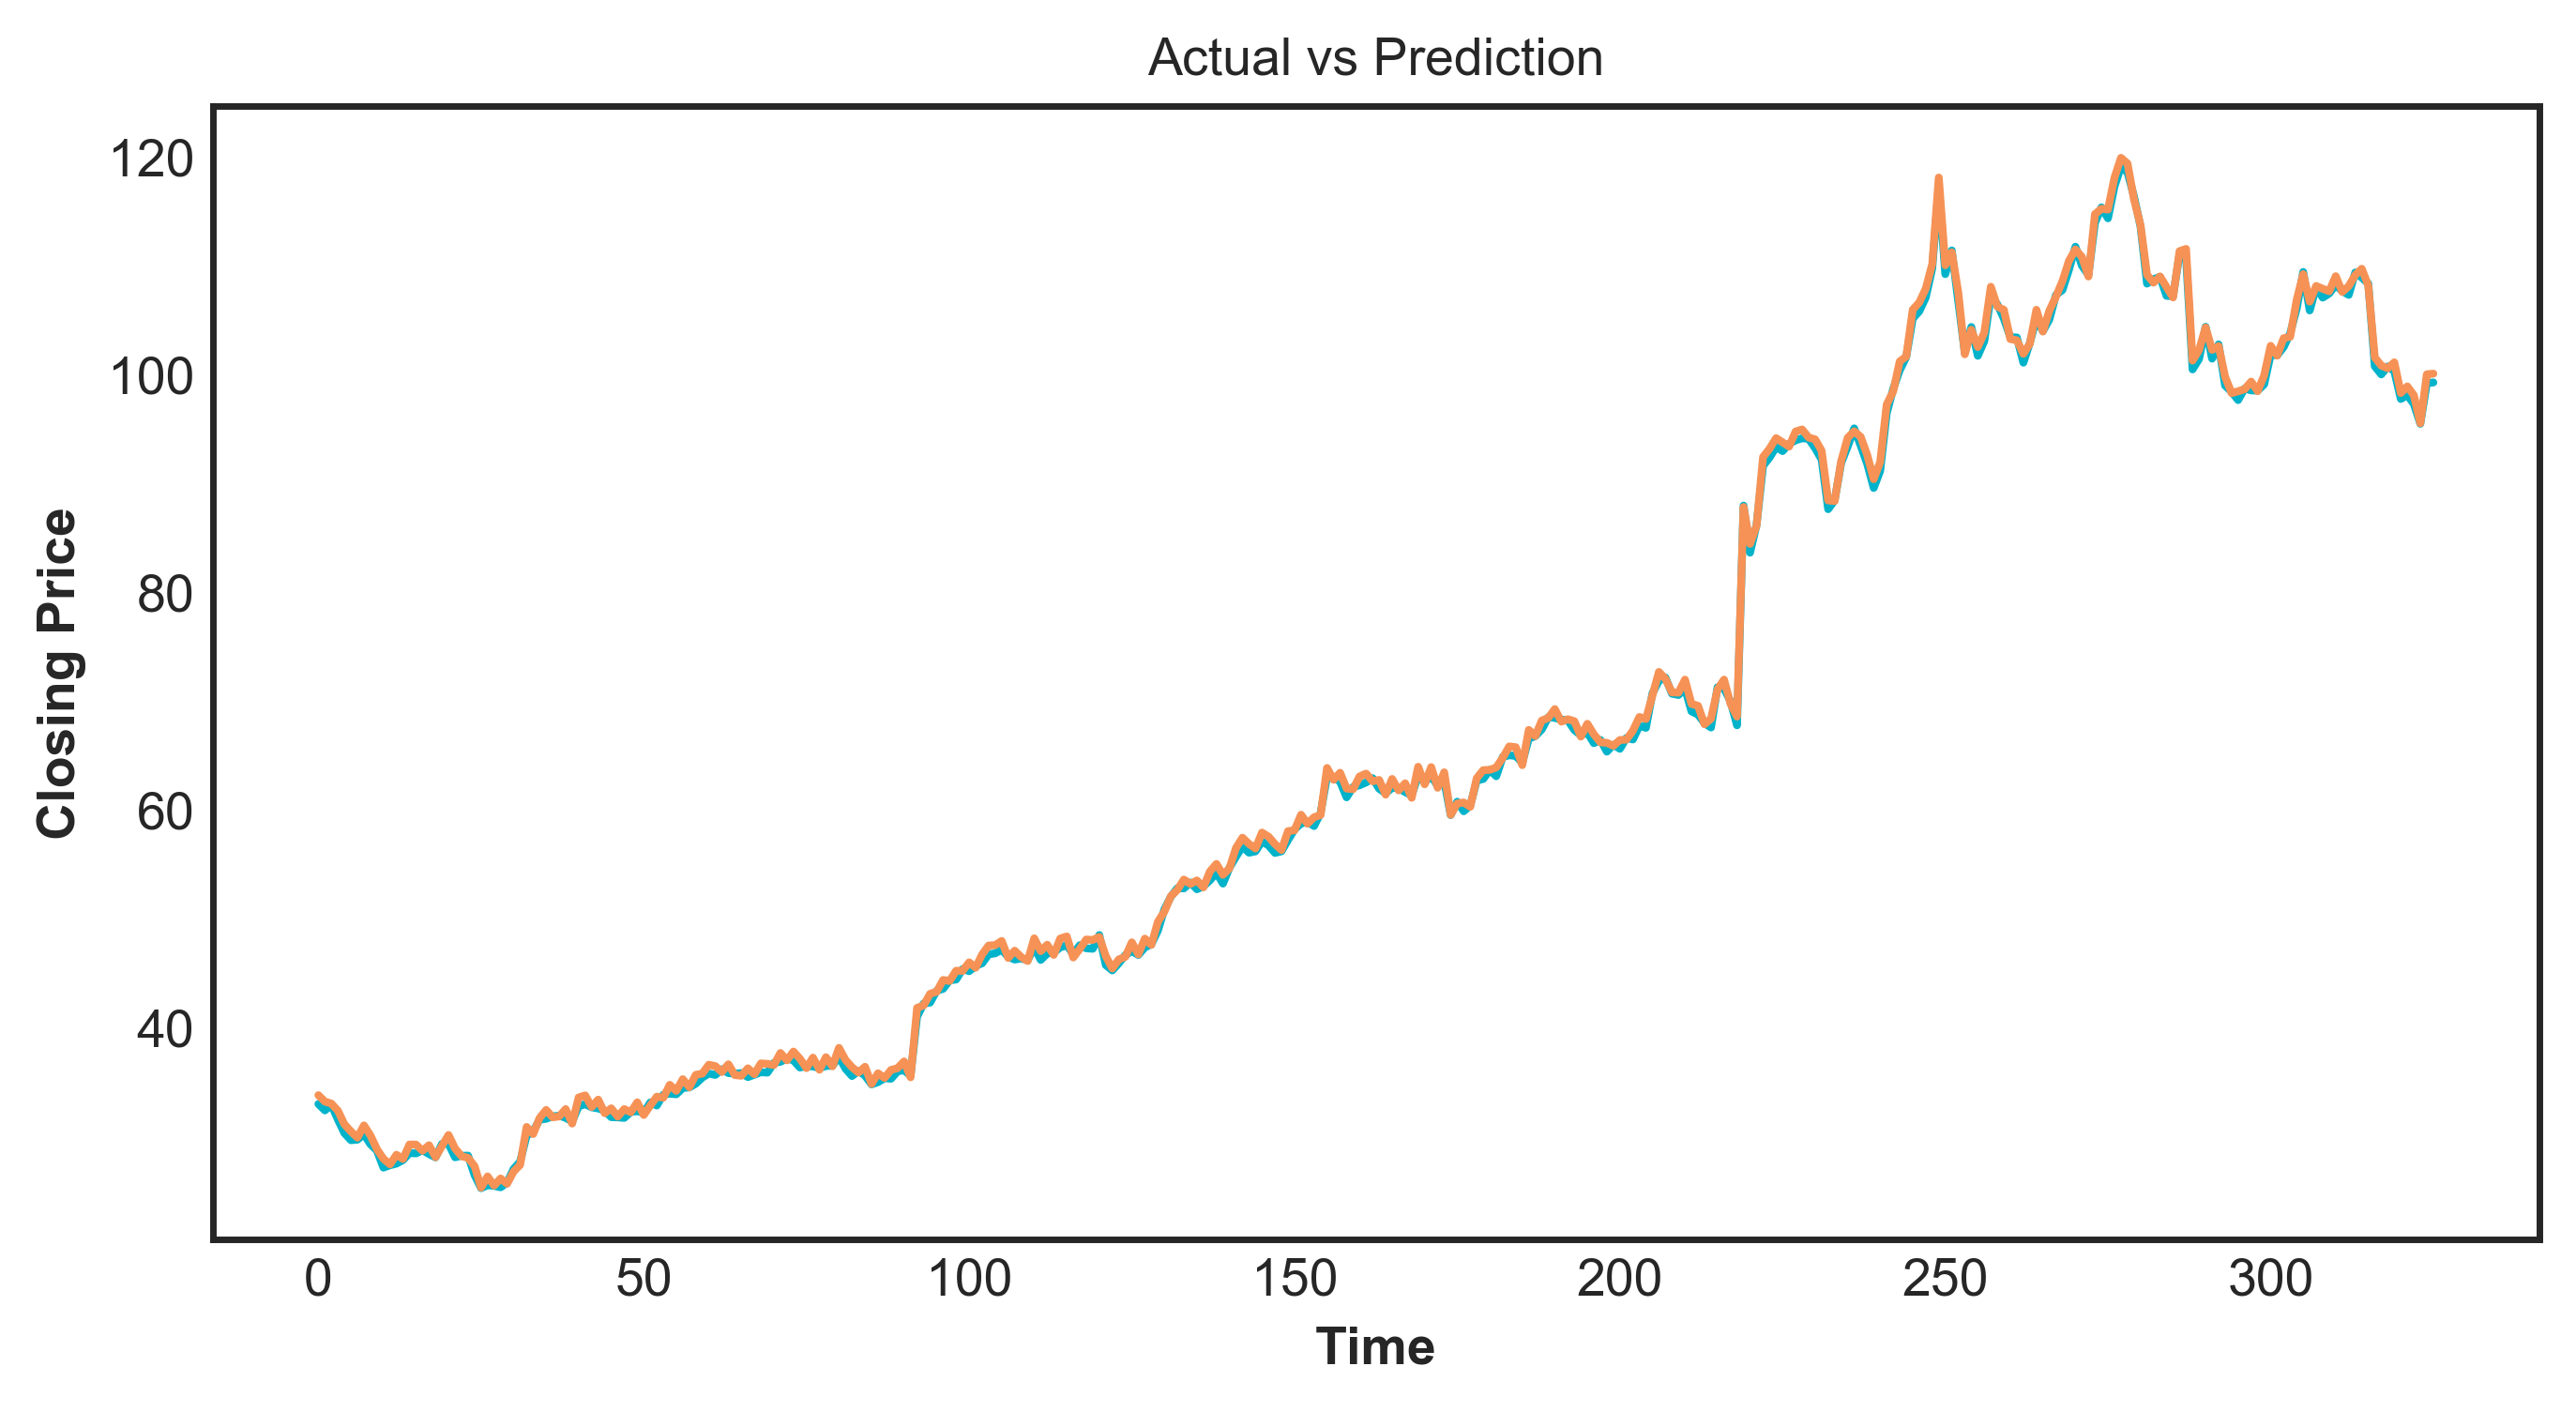

In [15]:
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction')
plt.plot(stocks[0].iloc[:training_size, :].values, color = "#00b3ca", label='Actual')
plt.plot(training_predictions, color = "#f69256", label='Prediction')
plt.show()

## Test Outcome

In [19]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse+' (%.4f' % (rmse/test_predictions[-1][0]*100) +'%)')

Test RMSE: 3.8642 (1.8362%)


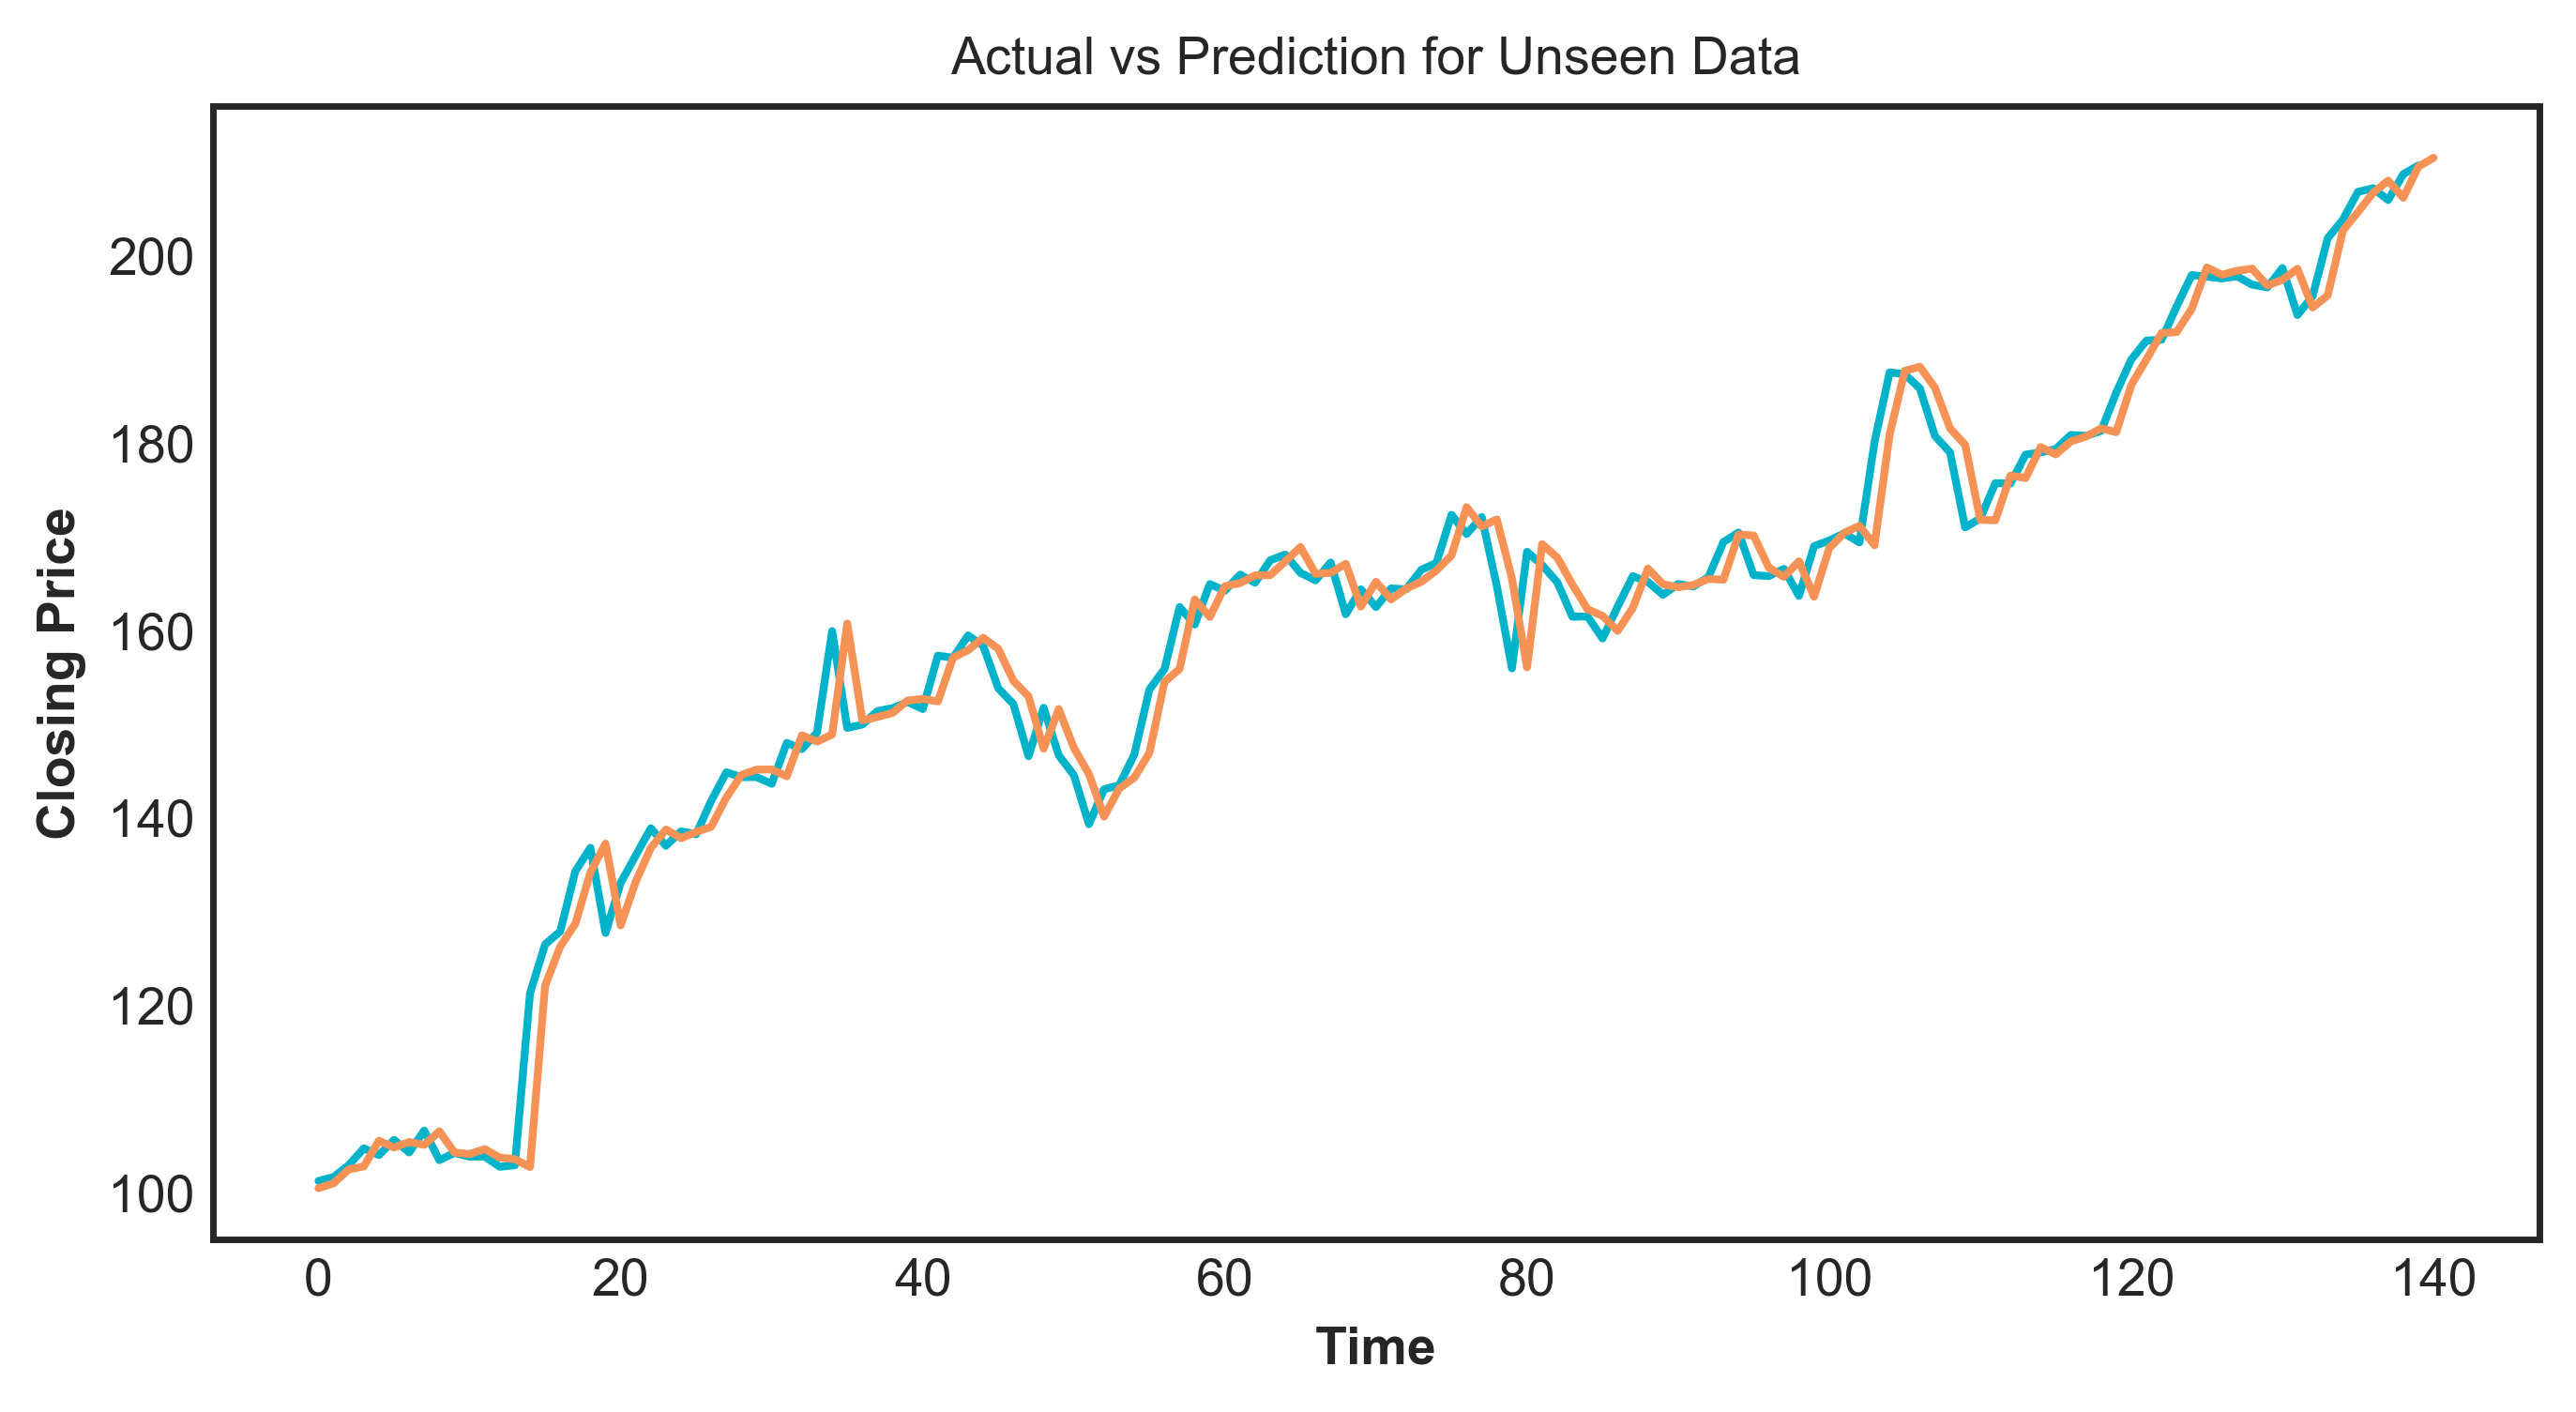

In [17]:
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.plot(stocks[0].iloc[training_size+1:, :].values, color = "#00b3ca",label='Actual')
plt.plot(test_predictions, color = "#f69256", label='Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction for Unseen Data')
plt.show()

## Forecasted Price
7/11/2017 is the day we bought the stocks, while 6/11/2017 is the day where we predict a rise in price.

In [18]:
print("Closing Price 6/11/2017")
print(stocks[0].iloc[-1:,:1].values[0][0])
print('\n')
print("Predicted Closing Price on 7/11/2017")
print(test_predictions[-1][0])

Closing Price 6/11/2017
209.630005


Predicted Closing Price on 7/11/2017
210.439
